<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v3)
Currently just a bunch of random experiments.

But I'll probably later re-use it for more interesting things.

In [6]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at df59263 Parameterise option to mask out output maps in training data
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 274 bytes | 91.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   df59263..061b0bd  main       -> origin/main
Updating df59263..061b0bd
Fast-forward
 slam_data.py | 1 -
 1 file changed, 1 deletion(-)


<module 'slam_data' from '/content/repo/slam_data.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
import datetime
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00


In [4]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data2.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data2.npz


RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0
Generating 1000 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [0 1 2 3]
Input maps: using floorplan samples only
Generating training data...


100%|██████████| 1000/1000 [01:00<00:00, 16.60it/s]


Generated 1000 samples after 1000 attempts
Dataset tests passed (1000 entries verified)
input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


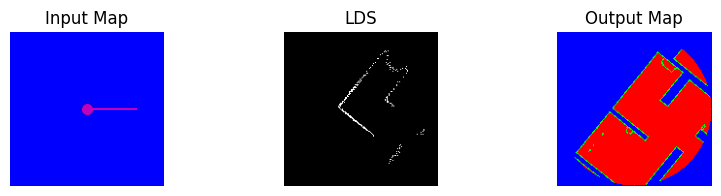

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.06650611 -0.1320825  -0.31531525]
metadata:   [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


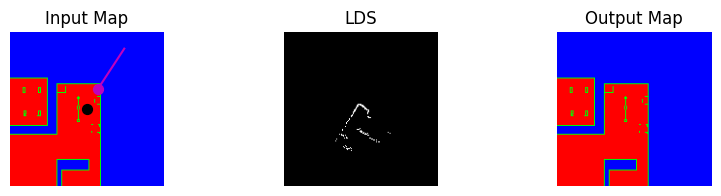

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.08753846  0.48659375 -0.07261062]
metadata:   [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


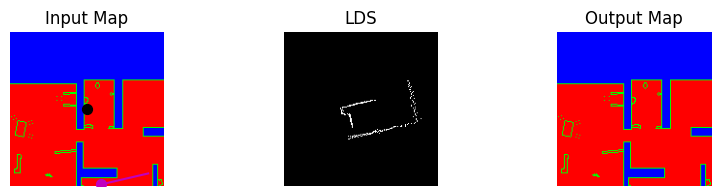

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


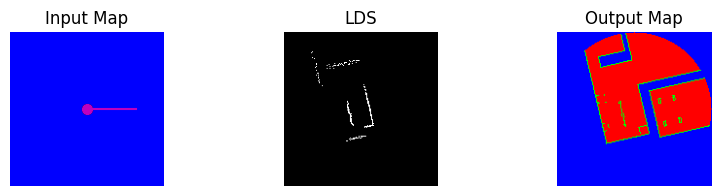

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.         -0.04257149 -0.08866958  0.0635903 ]
metadata:   [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


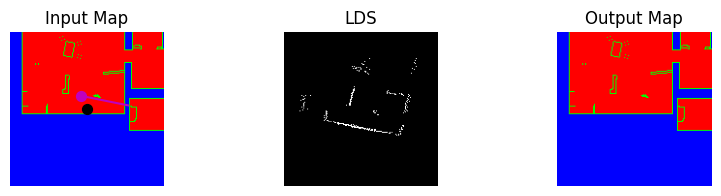

In [7]:
# Generate new training data with different option
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

reload(slam_data)
np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, 1000, mask_output_map_by_sample_type=False)
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)
train_data = dataset

In [8]:
slam_data.save_dataset(dataset, 'experimental-slam-training-data3.npz')

Saving:
  input_maps:  (1000, 159, 159, 3)
  lds_maps:    (1000, 159, 159)
  output_maps: (1000, 159, 159, 3)
  adlos:       (1000, 4)
  metadatas:   (1000, 8)
Dataset saved to experimental-slam-training-data3.npz


## Using dataset2
With output maps masked out in training data for sample types 2 and 3.

map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_51>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_57>]
  Compiled:         True
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - adlo_output_accept_accuracy: 0.6178 - adlo_output_adlo_loss: 2.0937 - adlo_output_loc_error: 0.2049 - adlo_output_orientation_error: 0.0167 - loss: 2.8592 - map_output_accuracy: 0.5325 - map_output_map_loss: 0.7643
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - adlo_output_accept_accuracy: 0.7290 - adlo_output_adlo_loss: 0.6063 - adlo_outpu

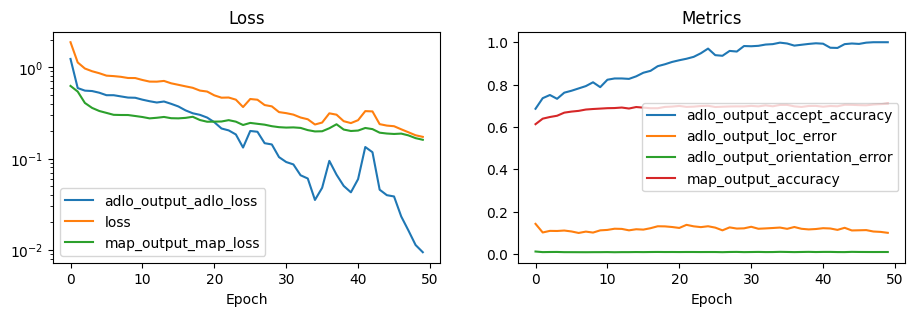

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 8.24901295e+00  4.80024470e-03  5.46573028e-02 -1.02966934e-01]
adlo-pred scaled: [ 0.9997385   0.00480024  0.0546573  -0.10296693]


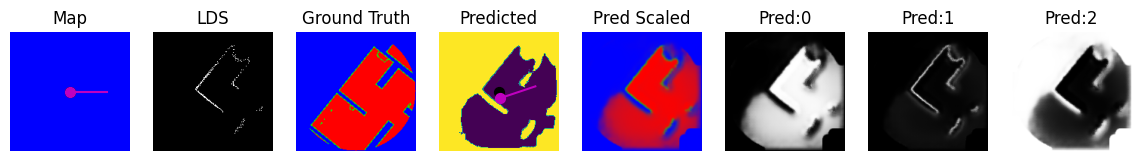

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 8.155082    0.02225174 -0.12770069 -0.26635757]
adlo-pred scaled: [ 0.99971277  0.02225174 -0.12770069 -0.26635757]


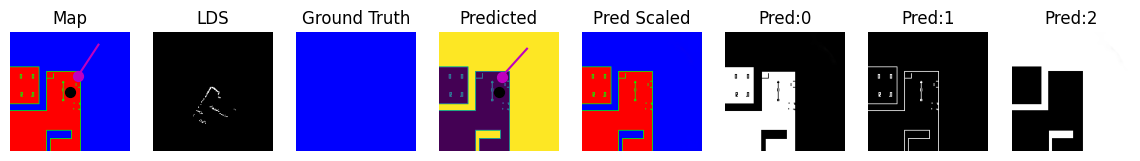

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [10.250238    0.03591366  0.32888988 -0.09190302]
adlo-pred scaled: [ 0.9999646   0.03591366  0.32888988 -0.09190302]


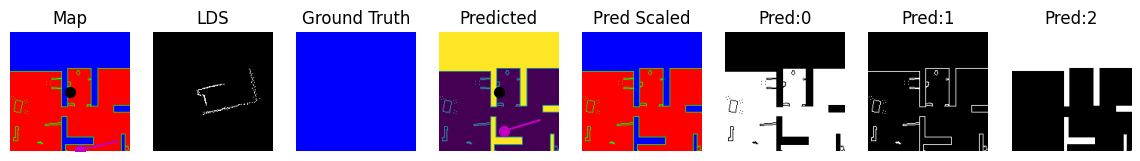

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.5867233  -0.01311956  0.00681579 -0.03552079]
adlo-pred scaled: [ 0.9986234  -0.01311956  0.00681579 -0.03552079]


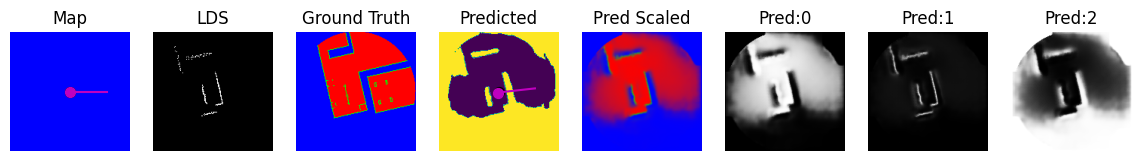

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 7.2646174  -0.03351796 -0.03955394  0.0300028 ]
adlo-pred scaled: [ 0.9993006  -0.03351796 -0.03955394  0.0300028 ]


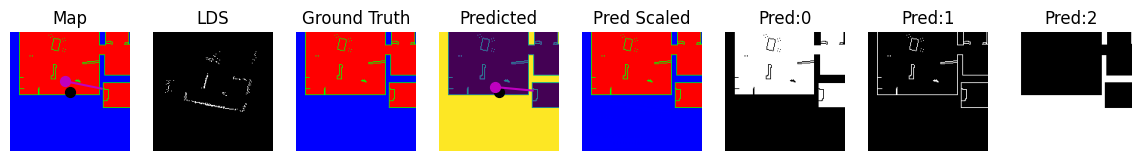

In [5]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256, compile=True, verbose_history=True)

epochs = 50
batch_size = 32
model_train_data = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
#tf.config.run_functions_eagerly(False)
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

## Lessons
Poor map prediction learning curve:
* I think that blanking out the ground-truth output map is counterproductive. The training still takes the same amount of time for a given batch, even though it's ignoring the predicted map. This means that training of map prediction is effectively slower.

* Perhaps it comes at the benefit of allowing the ADLO block to train slightly more accurately during the "Search" mode usage. But it's unlikely to be a significant benefit.

* I think I need a different perspective.

* Let's say that, during "Search", we want the model to output a map prediction based on the LDS map even when it rejects the input map, and that we're going to use that predicted map to help locate ourselves in the larger map.

## Using dataset3

In [11]:
# Load training data
#train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data3.npz')
train_data = slam_data.load_dataset('experimental-slam-training-data3.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from experimental-slam-training-data3.npz


map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_51>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_57>]
  Compiled:         True
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - adlo_output_accept_accuracy: 0.6841 - adlo_output_adlo_loss: 1.7582 - adlo_output_loc_error: 0.2028 - adlo_output_orientation_error: 0.0164 - loss: 2.6053 - map_output_accuracy: 0.6287 - map_output_map_loss: 0.8461
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - adlo_output_accept_accuracy: 0.7290 - adlo_output_adlo_loss: 0.6633 - adlo_outpu

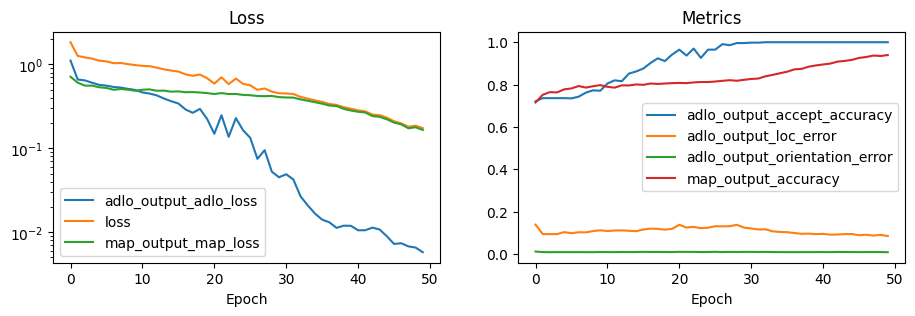

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 8.005882   -0.01370717 -0.01208914  0.01947992]
adlo-pred scaled: [ 0.9996666  -0.01370717 -0.01208914  0.01947992]


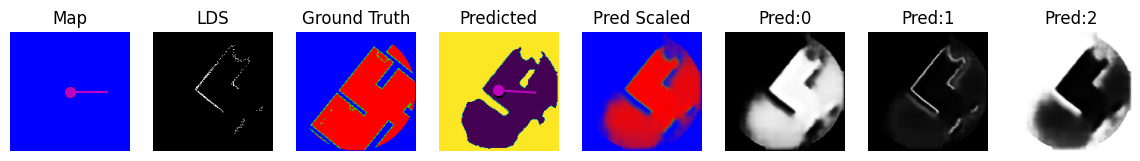

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 7.172361    0.05456392 -0.08633786 -0.25199327]
adlo-pred scaled: [ 0.9992331   0.05456392 -0.08633786 -0.25199327]


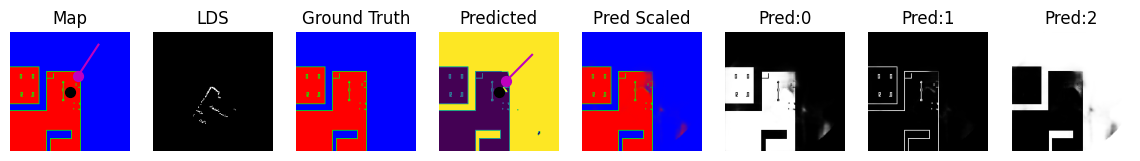

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [9.260421   0.03143948 0.18845165 0.01411049]
adlo-pred scaled: [0.9999049  0.03143948 0.18845165 0.01411049]


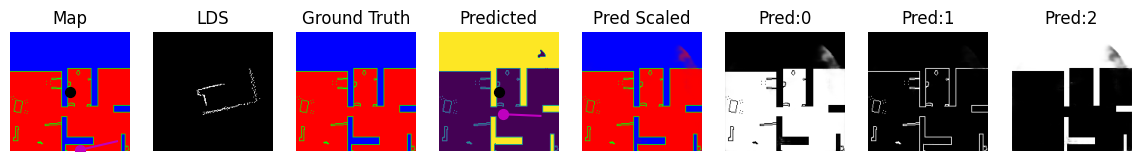

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.547476    0.00766199 -0.01244324  0.01605132]
adlo-pred scaled: [ 0.99611783  0.00766199 -0.01244324  0.01605132]


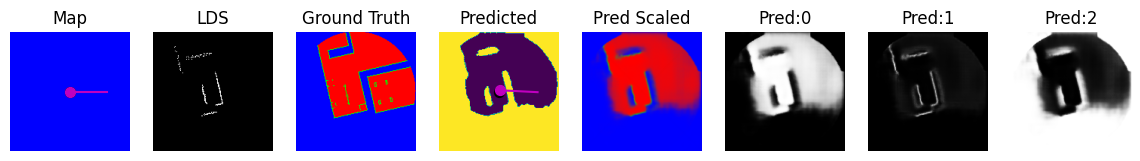

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 1.2093297e+01 -9.9741220e-03 -7.4327186e-02  5.6455813e-02]
adlo-pred scaled: [ 0.9999944  -0.00997412 -0.07432719  0.05645581]


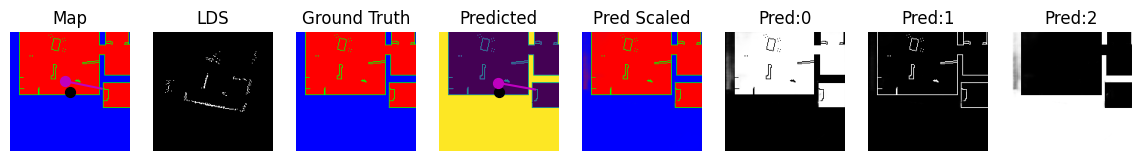

In [12]:
reload(slam)
reload(slam_data)

one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256, compile=True, verbose_history=True)

epochs = 50
batch_size = 32
model_train_data = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
#tf.config.run_functions_eagerly(False)
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 8.005883   -0.01370721 -0.01208915  0.01948   ]
adlo-pred scaled: [ 0.9996666  -0.01370721 -0.01208915  0.01948   ]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


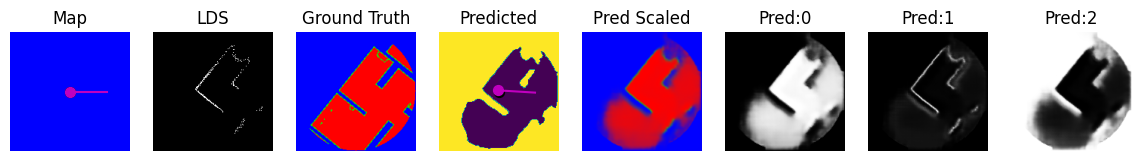

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 7.172354    0.05456396 -0.086338   -0.25199318]
adlo-pred scaled: [ 0.9992331   0.05456396 -0.086338   -0.25199318]
metadata:         [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


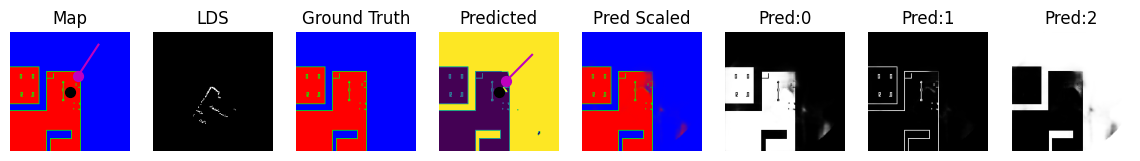

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [9.26043    0.0314394  0.18845156 0.01411034]
adlo-pred scaled: [0.9999049  0.0314394  0.18845156 0.01411034]
metadata:         [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


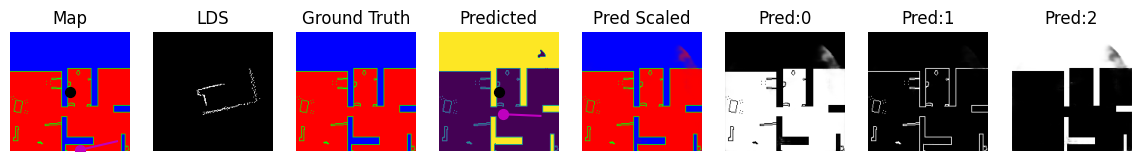

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.5474753   0.00766202 -0.0124433   0.01605137]
adlo-pred scaled: [ 0.99611783  0.00766202 -0.0124433   0.01605137]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


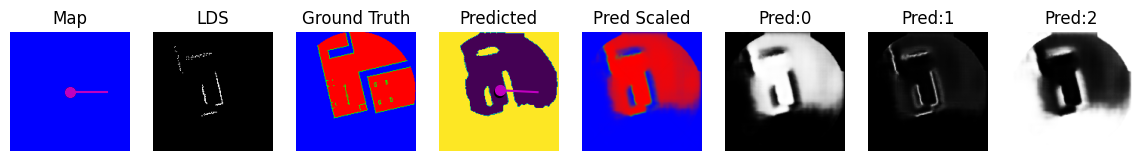

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 1.2093300e+01 -9.9741668e-03 -7.4327223e-02  5.6455754e-02]
adlo-pred scaled: [ 0.9999944  -0.00997417 -0.07432722  0.05645575]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


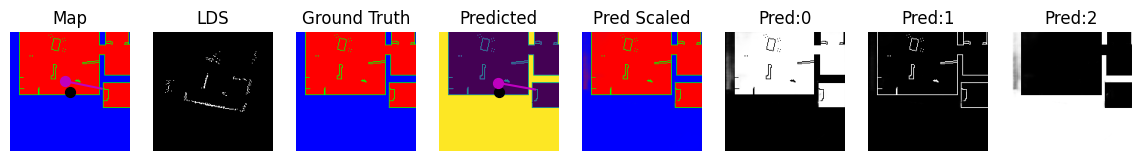

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 8.954077    0.01261513 -0.03110175  0.01817477]
adlo-pred scaled: [ 0.9998708   0.01261513 -0.03110175  0.01817477]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


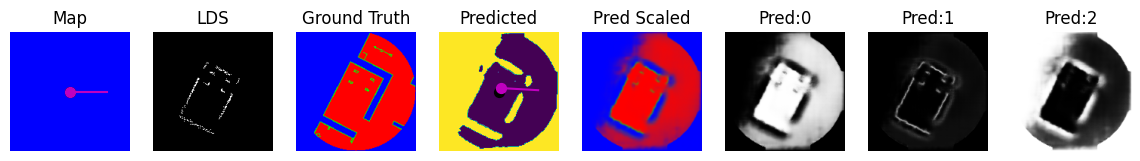

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [10.005534   -0.06213896  0.04936976  0.06320941]
adlo-pred scaled: [ 0.9999548  -0.06213896  0.04936976  0.06320941]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


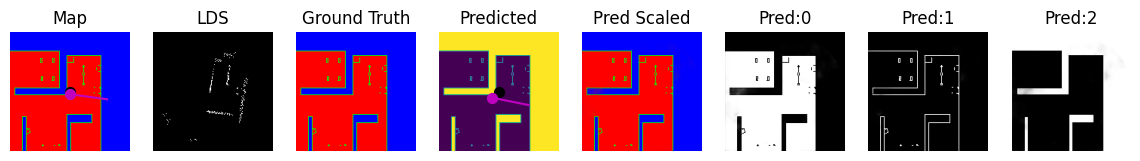

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 8.31170750e+00  1.11746244e-01 -4.99863783e-03 -1.14566116e-02]
adlo-pred scaled: [ 0.9997545   0.11174624 -0.00499864 -0.01145661]
metadata:         [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


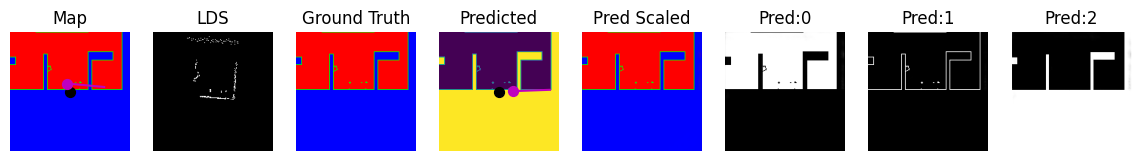

adlo:             [ 1.          0.00217839 -0.12877417  0.7317692 ]
adlo-pred raw:    [ 9.336854    0.06957395 -0.20266174  0.63748187]
adlo-pred scaled: [ 0.9999119   0.06957395 -0.20266174  0.63748187]
metadata:         [ 2.0000000e+00  2.0000000e+00  5.7226862e+02  4.7020596e+03
  0.0000000e+00  5.8775458e+02  3.7866182e+03 -1.0451387e+00]


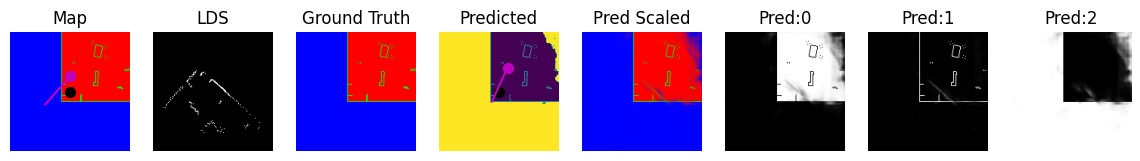

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-19.042633    -0.28483498  -0.31178984   0.7505498 ]
adlo-pred scaled: [ 5.3689524e-09 -2.8483498e-01 -3.1178984e-01  7.5054979e-01]
metadata:         [ 2.0000000e+00  3.0000000e+00  9.3436310e+02  5.0657603e+03
  0.0000000e+00  7.2652407e+03  4.8334370e+03 -2.9795210e+00]


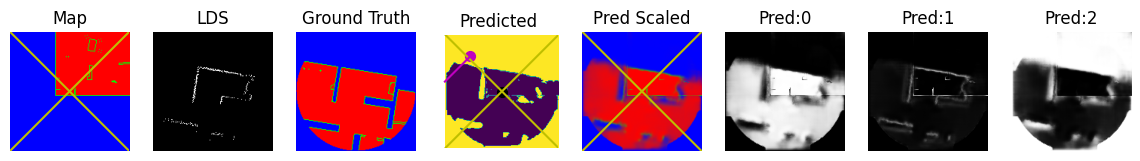

In [15]:
reload(slam_data)
slam_data.show_predictions(model, train_data, 10, show_classes='pred')

## Using a better activation and loss function for DLO outputs
Both the tanh() activation function and the log-cosh loss functions currently used against the -DLO output components are doing the opposite of what I want. I want errors to be more heavily punished when close to the exact spot than when the agent is far from the exact correct location. This is so that the model learns to be very accurate.

When the agent is far from the estimated location, an approximate error is fine.
I've probably largely solved this by having the loss function completely ignore the -DLO component when accept=false, but it's still being applied when in "search" mode and accept=true.

At the very least, I want a linear response curve, rather than one that punishes larger errors more.



## Checking that we can save and reload
With all the custom functions this might need some extra special work.

In [ ]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

loss = slam.ADLOLoss()
model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })
epochs = 1
batch_size = 32
tf.config.run_functions_eagerly(True)
model_train_data = train_data.take(64).shuffle(buffer_size=64).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
model_history = model.fit(model_train_data, epochs=epochs)

map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_957>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_963>]
2/2 ━━━━━━━━━━━━━━━━━━━━ 102s 46s/step - adlo_output_accept_accuracy: 0.7812 - adlo_output_adlo_loss: 1.0816 - adlo_output_loc_error: 0.3345 - adlo_output_orientation_error: 0.0210 - loss: 2.1976 - map_output_accuracy: 0.2209 - map_output_loss: 1.1160


In [ ]:
# save model to disk for getting back into this later
model.save('experimental-slam-model3-100epochs.keras')

In [ ]:
# ...or relead
import tensorflow as tf
loaded = tf.keras.models.load_model('model.keras')

In [ ]:
loaded.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lds_input (InputLayer)    │ (None, 149, 149)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ map_input (InputLayer)    │ (None, 149, 149, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 149, 149, 1)    │              0 │ lds_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_14         │ (None, 160, 160, 3)    │              0 │ map_input[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_15         │ (None, 160, 160, 1)    │              0 │ reshape_7[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_203 (Conv2D)       │ (None, 160, 160, 32)   │            896 │ zero_padding2d_14[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_211 (Conv2D)       │ (None, 160, 160, 32)   │            320 │ zero_padding2d_15[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_204 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_203[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_212 (Conv2D)       │ (None, 160, 160, 32)   │          9,248 │ conv2d_211[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_56          │ (None, 80, 80, 32)     │              0 │ conv2d_204[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_60          │ (None, 80, 80, 32)     │              0 │ conv2d_212[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_205 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_56[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_213 (Conv2D)       │ (None, 80, 80, 64)     │         18,496 │ max_pooling2d_60[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_206 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_205[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_214 (Conv2D)       │ (None, 80, 80, 64)     │         36,928 │ conv2d_213[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_57          │ (None, 40, 40, 64)     │              0 │ conv2d_206[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_61          │ (None, 40, 40, 64)     │              0 │ conv2d_214[0][0]       │
│ (MaxPooling2D)       

 Total params: 36,974,759 (141.05 MB)

 Trainable params: 12,324,919 (47.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,649,840 (94.03 MB)

In [ ]:
l = slam.ADLOLoss()
l.get_config()


{'name': 'adlo_loss', 'reduction': 'sum_over_batch_size', '_from_logits': True}

## Train with prediction-generated input maps


Loaded:
  input_maps:        (1000, 159, 159, 3)
  lds_maps:          (1000, 159, 159)
  ground_truth_maps: (1000, 159, 159, 3)
  adlos:             (1000, 4)
Dataset loaded from experimental-slam-training-data2.npz
input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.3613129  -0.14542208 -0.84998183]


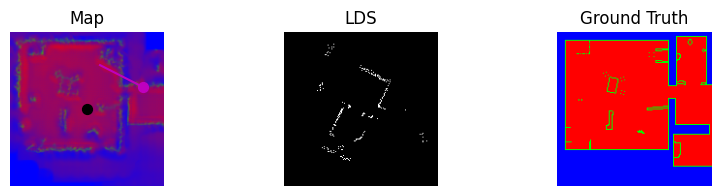

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [1. 0. 0. 0.]


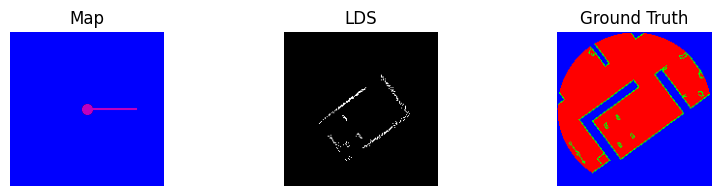

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.         -0.4288581  -0.16917454  0.88887873]


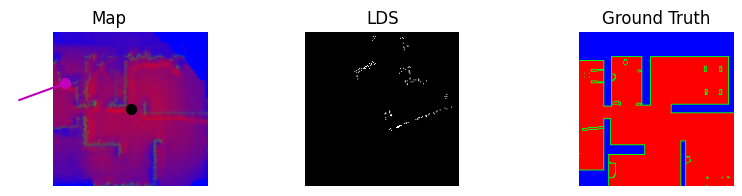

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [ 1.          0.08887662 -0.4728966  -0.44646913]


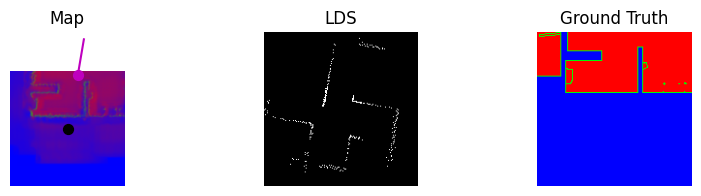

input_map:        (159, 159, 3)
lds_map:          (159, 159)
ground_truth_map: (159, 159, 3)
adlo:             [0. 0. 0. 0.]


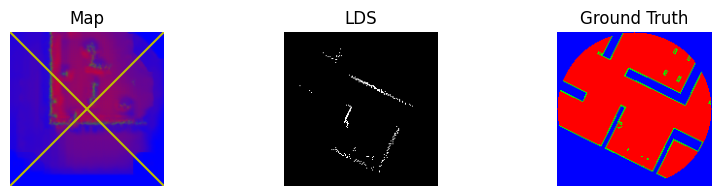

In [ ]:
# load training data
train_data = slam_data.load_dataset('experimental-slam-training-data2.npz')
slam_data.show_dataset(train_data)

map_shape: (159, 159, 3)
Added final cropping layer: w=1, h=1
Prepared SLAM model
  Map shape:        (159, 159, 3) + padding (1, 1, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 159, 159), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 159, 159, 3), dtype=float32, sparse=False, name=keras_tensor_109>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_115>]
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - adlo_output_accept_accuracy: 0.6945 - adlo_output_adlo_loss: 0.8452 - adlo_output_loc_error: 0.1518 - adlo_output_orientation_error: 0.0130 - loss: 1.7051 - map_output_accuracy: 0.5522 - map_output_loss: 0.8596
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - adlo_output_accept_accuracy: 0.7479 - adlo_output_adlo_loss: 0.5027 - adlo_output_loc_error: 0.0937 - 

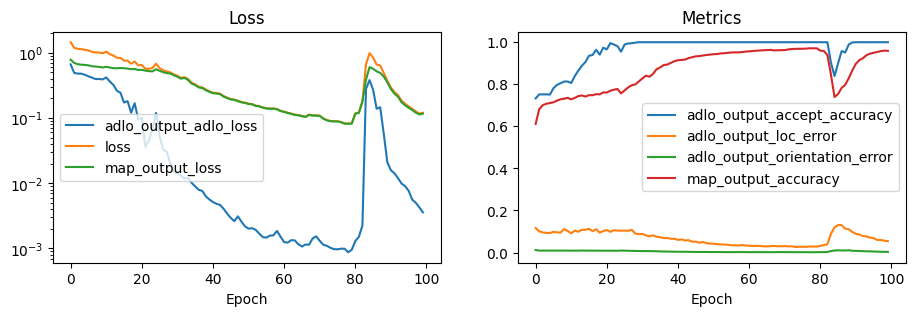

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
adlo:             [ 1.          0.3613129  -0.14542208 -0.84998183]
adlo-pred raw:    [10.507726    0.343536   -0.05889685 -0.85207283]
adlo-pred scaled: [ 0.9999727   0.343536   -0.05889685 -0.85207283]


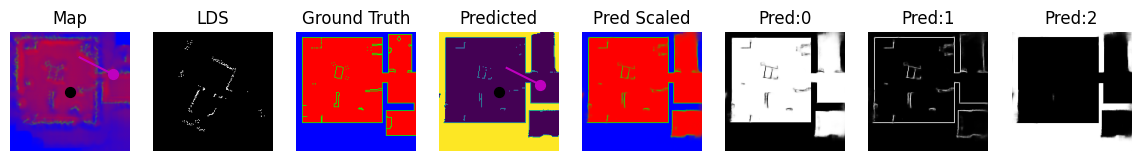

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 9.4432831e+00  5.7364977e-03  1.0094456e-02 -1.2690397e-02]
adlo-pred scaled: [ 0.9999207   0.0057365   0.01009446 -0.0126904 ]


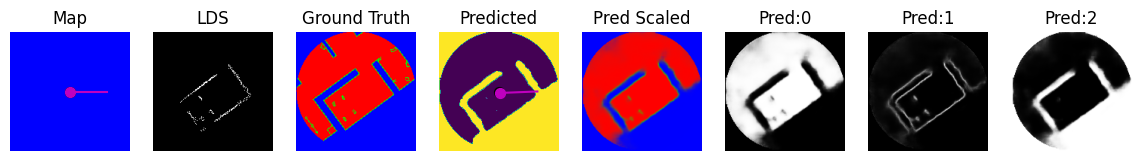

adlo:             [ 1.         -0.4288581  -0.16917454  0.88887873]
adlo-pred raw:    [ 9.469109   -0.15439604  0.01706392  0.759846  ]
adlo-pred scaled: [ 0.99992275 -0.15439604  0.01706392  0.759846  ]


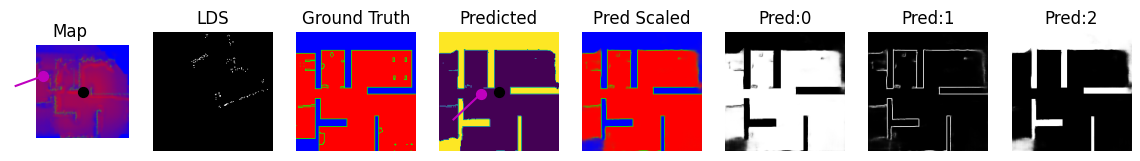

adlo:             [ 1.          0.08887662 -0.4728966  -0.44646913]
adlo-pred raw:    [16.434385    0.07027622 -0.3425067  -0.4342132 ]
adlo-pred scaled: [ 0.9999999   0.07027622 -0.3425067  -0.4342132 ]


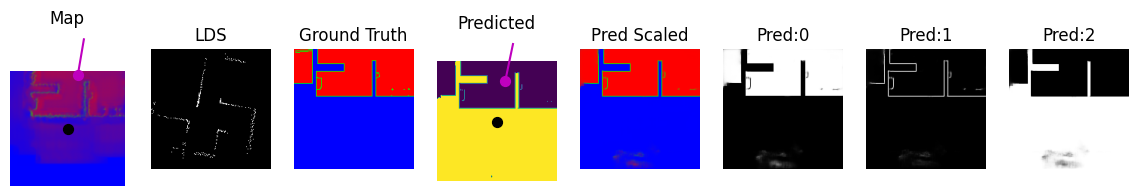

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-9.2079945e+00 -1.4672731e-02 -9.5060095e-05 -1.2263964e-02]
adlo-pred scaled: [ 1.0022482e-04 -1.4672731e-02 -9.5060095e-05 -1.2263964e-02]


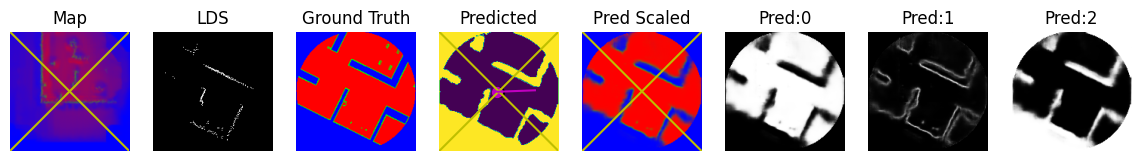

In [ ]:
reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': slam.ADLOLoss()
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='loss'), 'accuracy'],
                  'adlo_output': [slam.ADLOLoss(), slam.AcceptAccuracy(), slam.LocationError(), slam.OrientationError()]
              })

epochs = 100
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')